<a href="https://colab.research.google.com/github/sv650s/amazon-review-classification/blob/master/notebooks/deep_learning/6.1.2-LSTMB16-500k-prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Prototype (16 units Balanced Weights)

In previous notebook, we ran a network with 16 LSTM units on 200k samples.

Our score was 0.299

In this notebook, we will run the same network but with 500k examples.

# Result

For 500k samples, our score is: 0.3849584800258859


In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow 2.x selected.


'/device:GPU:0'

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, \
    SpatialDropout1D, Flatten, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import model_to_dot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight




import random
import pandas as pd
import numpy as np
from IPython.display import SVG
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging


import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku
import util.report_util as ru

# fix random seeds
tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(1)
random.seed(1)
np.random.seed(1)



logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set()


DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
LABEL_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"


DEBUG = False


LSTM_DIM = 16 # total LSTM units
MODEL_NAME = f"LSTMB{LSTM_DIM}"
ARCHITECTURE = f"1x{LSTM_DIM}"
DESCRIPTION = f"1 Layer {LSTM_DIM} LSTM Units and 20% 1D Spatial Dropout - Balanced Weights"
FEATURE_SET_NAME = "random_embedding"
PATIENCE = 2

if DEBUG:
  DATA_FILE = f'{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-test-preprocessed.csv'
  MODEL_NAME = f'test-{MODEL_NAME}'
else:
  DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-500k-preprocessed.csv"


# first layer filter
FILTER1 = 32
# Network Settings
KERNEL_SIZE=3



# length of our embedding - 300 is standard
EMBED_SIZE = 300
EPOCHS  = 50
BATCH_SIZE = 128

# From EDA, we know that 90% of review bodies have 100 words or less, 
# we will use this as our sequence length
MAX_SEQUENCE_LENGTH = 100



In [0]:
df = pd.read_csv(DATA_FILE)

rating = df[LABEL_COLUMN]
reviews = df[REVIEW_COLUMN]

# Preprocessing

In [4]:


# pre-process our lables
# one hot encode our star ratings since Keras/TF requires this for the labels
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()


# split our data into train and test sets
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, y, random_state=1)


# Pre-process our features (review body)
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(reviews_train)
# tokenize both our training and test data
train_sequences = t.texts_to_sequences(reviews_train)
test_sequences = t.texts_to_sequences(reviews_test)

print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))


# pad our reviews to the max sequence length
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Train review vectors shape:', X_train.shape, ' Test review vectors shape:', X_test.shape)


Vocabulary size=73964
Number of Documents=373376
Train review vectors shape: (373376, 100)  Test review vectors shape: (124459, 100)


**Build LSTM Model Architecture**

In [0]:
vocab_size = len(t.word_counts)+1

# building our network
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(LSTM_DIM))
model.add(Dense(5, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["categorical_accuracy"])


In [6]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          22189500  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 16)                20288     
_________________________________________________________________
dense (Dense)                (None, 5)                 85        
Total params: 22,209,873
Trainable params: 22,209,873
Non-trainable params: 0
_________________________________________________________________
None


In [7]:

# reduce learning rate if we sense a plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                            #   factor=0.4,
                            #   patience=PATIENCE, 
                            #   min_lr=0.00001,
                            #  mode='auto',
                              restore_best_weights=True)

early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

weights = compute_class_weight('balanced', np.arange(1, 6), rating)
print(f'class weights: {weights}')


mw = ku.ModelWrapper(model, 
                     MODEL_NAME, 
                     ARCHITECTURE,
                     FEATURE_SET_NAME,
                     LABEL_COLUMN, 
                     DATA_FILE, 
                     embed_size=EMBED_SIZE,
                     tokenizer=t,
                     description=DESCRIPTION)

network_history = mw.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      class_weight=weights,
                      callbacks=[early_stop, reduce_lr])

class weights: [1.41902061 3.0309589  2.20828158 1.20167276 0.37308618]
Number of training examples: 373376
Train on 298700 samples, validate on 74676 samples
Epoch 1/50
298700/298700 [==============================] - 529s 2ms/sample - loss: 0.8624 - categorical_accuracy: 0.6673 - val_loss: 0.7951 - val_categorical_accuracy: 0.6890
Epoch 2/50
298700/298700 [==============================] - 522s 2ms/sample - loss: 0.7460 - categorical_accuracy: 0.7083 - val_loss: 0.7882 - val_categorical_accuracy: 0.6942
Epoch 3/50
298700/298700 [==============================] - 526s 2ms/sample - loss: 0.6854 - categorical_accuracy: 0.7334 - val_loss: 0.7892 - val_categorical_accuracy: 0.6942
Epoch 4/50
298700/298700 [==============================] - 516s 2ms/sample - loss: 0.6338 - categorical_accuracy: 0.7550 - val_loss: 0.8169 - val_categorical_accuracy: 0.6857
Epoch 00004: early stopping


Number of test: 124459
Running model.evaluate...
124459/124459 [==============================] - 22s 174us/sample - loss: 0.8193 - categorical_accuracy: 0.6856
Running model.predict...
Unencode predictions...
Generating confusion matrix...
Calculating ROC AUC...
(124459, 5)
Getting classification report...
Accuracy: 68.56%


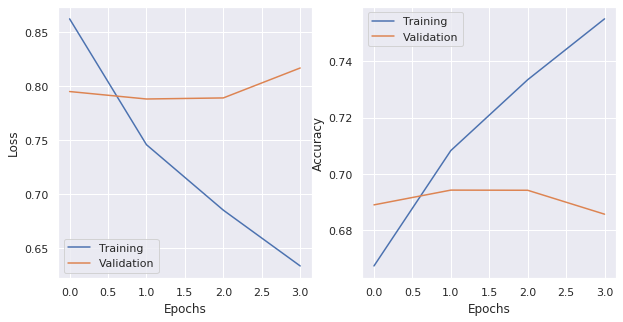


Confusion Matrix
[[13500  1862  1026   370   902]
 [ 3271  1924  1607   689   709]
 [ 1589  1439  3534  2532  2209]
 [  481   461  1909  6987 10925]
 [  684   272  1057  5134 59386]]

Classification Report
              precision    recall  f1-score   support

           1       0.69      0.76      0.73     17660
           2       0.32      0.23      0.27      8200
           3       0.39      0.31      0.35     11303
           4       0.44      0.34      0.38     20763
           5       0.80      0.89      0.84     66533

    accuracy                           0.69    124459
   macro avg       0.53      0.51      0.51    124459
weighted avg       0.66      0.69      0.67    124459



drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  w

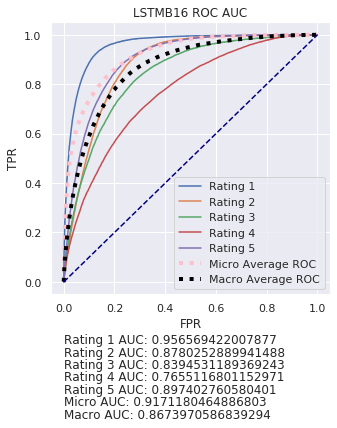

In [8]:

scores = mw.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (mw.scores[1]*100))

pu.plot_network_history(mw.network_history, "categorical_accuracy", "val_categorical_accuracy")
plt.show()

print("\nConfusion Matrix")
print(mw.confusion_matrix)

print("\nClassification Report")
print(mw.classification_report)

fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw.model_name, mw.roc_auc, mw.fpr, mw.tpr)



In [9]:
print(f'Score: {ru.calculate_metric(mw.crd)}')

Score: 0.3849584800258859


**Save off various files**

In [10]:
mw.save(DRIVE_DIR, append_report=True)

description: LSTMB16-1x16-random_embedding-sampling_none-497835-100-star_rating
Saving model file: drive/My Drive/Springboard/capstone/models/LSTMB16-1x16-random_embedding-sampling_none-497835-100-star_rating-model.h5
Saving json config file: drive/My Drive/Springboard/capstone/models/LSTMB16-1x16-random_embedding-sampling_none-497835-100-star_rating-model.json
Saving weights file: drive/My Drive/Springboard/capstone/models/LSTMB16-1x16-random_embedding-sampling_none-497835-100-star_rating-weights.h5
Saving history file: drive/My Drive/Springboard/capstone/models/LSTMB16-1x16-random_embedding-sampling_none-497835-100-star_rating-history.h5


TypeError: ignored

In [0]:
print(datetime.now())